In [54]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

In [67]:
# Load data from detailed_listings into a Pandas DataFrame
file_listing= f'data/London/detailed_listings.csv'
columns_to_extract = [  'id',
                        'room_type',
                        'number_of_reviews',
                        'number_of_reviews_ltm',
                        'number_of_reviews_l30d',
                        'first_review',
                        'last_review',
                        'review_scores_rating',
                        'review_scores_accuracy',
                        'review_scores_cleanliness',
                        'review_scores_checkin',
                        'review_scores_communication',
                        'review_scores_location',
                        'review_scores_value']
dataframe_listing = pd.read_csv(file_listing, usecols=columns_to_extract)

# Load data from detailed_reviews into a Pandas DataFrame
file_review = f'data/London/detailed_reviews.csv'
columns_to_extract = [ 'listing_id',
                       'date',
                       'comments',]
dataframe_review = pd.read_csv(file_review, usecols=columns_to_extract)
# Filter out reviews before a certain year, 2017 for example
dataframe_review['date'] = pd.to_datetime(dataframe_review['date'])
dataframe_review = dataframe_review[dataframe_review['date'] >= '2017-01-01']

# Match two dataframes based on listing id
dataframe = pd.merge(dataframe_listing[['id', 'room_type', 'review_scores_rating']], 
               dataframe_review[['listing_id', 'date', 'comments']],
               left_on='id', right_on='listing_id', how='inner')
dataframe.drop('listing_id', axis=1, inplace=True)

# Check for empty 'comments' column and delete corresponding rows
dataframe = dataframe[dataframe['comments'].notna() & (dataframe['comments'] != '')]

# Fewer listings in dataframe_review than in dataframe_listing, so some listings in London not analysed on review sentiment
num_unique_ids_listing = dataframe_listing['id'].nunique()
print(f"Number of unique 'id' values in dataframe_listing: {num_unique_ids_listing}")
num_unique_ids_review = dataframe_review['listing_id'].nunique()
print(f"Number of unique 'listing_id' values in dataframe_review: {num_unique_ids_review}")

# Reorder columns
new_column_order = ['id', 'date','room_type', 'review_scores_rating', 'comments']
dataframe = dataframe[new_column_order]

display(dataframe.head())

Number of unique 'id' values in dataframe_listing: 91778
Number of unique 'listing_id' values in dataframe_review: 65259


,id,date,room_type,review_scores_rating,comments
0,198258,2017-06-10,Private room,4.74,Ryan was kind and accommodating. It was a great place for just needing to crash at night while being out and about in the day.
1,198258,2017-09-28,Private room,4.74,"Ryan was the perfect host. He's friendly, welcoming and a really lovely guy. The flat is in a brilliant location, is furnished to a really high-spec and the views are great. I had a couple of great nights sleep and it was lovely hanging out with Ryan over a glass of wine. <br/>I would definitely recommend Ryan and his flat."
2,198258,2017-10-15,Private room,4.74,Deuxième fois chez Ryan et sa bonne humeur fait toujours mouche. Je reviendrais encore ;)
3,198258,2018-06-30,Private room,4.74,Good location in Barking with Ryan (and Arthur the cat) both super friendly. Ryan had a wealth of knowledge in regards to what there is to do and services available around Barking and was always happy to chat and offer help with anything I needed.
4,198258,2018-07-24,Private room,4.74,Great place. Friendly host. Highly recommend


In [68]:
# Apply vaderSentiment (Non-English review can be analysed but based on translation tool, and require internet)
analyzer = SentimentIntensityAnalyzer()
dataframe['compound'] = dataframe['comments'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
dataframe['positive'] = dataframe['comments'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
dataframe['neutral'] = dataframe['comments'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
dataframe['negative'] = dataframe['comments'].apply(lambda x: analyzer.polarity_scores(x)['neg'])

# Display the DataFrame with sentiment analysis results
display(dataframe.head())

,id,date,room_type,review_scores_rating,comments,compound,positive,neutral,negative
0,198258,2017-06-10,Private room,4.74,Ryan was kind and accommodating. It was a great place for just needing to crash at night while being out and about in the day.,0.7003,0.233,0.683,0.084
1,198258,2017-09-28,Private room,4.74,"Ryan was the perfect host. He's friendly, welcoming and a really lovely guy. The flat is in a brilliant location, is furnished to a really high-spec and the views are great. I had a couple of great nights sleep and it was lovely hanging out with Ryan over a glass of wine. <br/>I would definitely recommend Ryan and his flat.",0.9881,0.411,0.589,0.000
2,198258,2017-10-15,Private room,4.74,Deuxième fois chez Ryan et sa bonne humeur fait toujours mouche. Je reviendrais encore ;),0.2263,0.119,0.881,0.000
3,198258,2018-06-30,Private room,4.74,Good location in Barking with Ryan (and Arthur the cat) both super friendly. Ryan had a wealth of knowledge in regards to what there is to do and services available around Barking and was always happy to chat and offer help with anything I needed.,0.9618,0.334,0.666,0.000
4,198258,2018-07-24,Private room,4.74,Great place. Friendly host. Highly recommend,0.8777,0.771,0.229,0.000


Correlation between Sentiment Scores and Rating Scores: 0.22
                            OLS Regression Results                            
Dep. Variable:      normalized_rating   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                 7.921e+04
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:02:39   Log-Likelihood:             2.3673e+06
No. Observations:             1489883   AIC:                        -4.735e+06
Df Residuals:                 1489881   BIC:                        -4.735e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

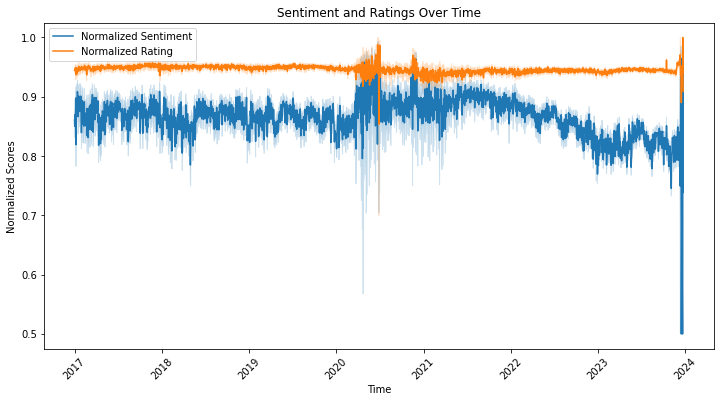

In [79]:
# Analysis examples: normalised sentiment and rating scores, regression analysis on correlation, and time-series analysis

from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize sentiment scores and rating scores to [0, 1]
scaler = MinMaxScaler()
dataframe['normalized_sentiment'] = scaler.fit_transform(dataframe[['compound']])
dataframe['normalized_rating'] = scaler.fit_transform(dataframe[['review_scores_rating']])

# Examine the correlation between sentiment scores and rating scores
correlation = dataframe['normalized_sentiment'].corr(dataframe['normalized_rating'])
print(f"Correlation between Sentiment Scores and Rating Scores: {correlation:.2f}")

# Regression analysis
X = sm.add_constant(dataframe[['normalized_sentiment']])
y = dataframe['normalized_rating']
model = sm.OLS(y, X).fit()

# Display regression summary 
# Results indicate a weak relationship between normalized sentiment scores and normalized rating scores
print(model.summary())

# Plot the normalized sentiment and rating scores over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='normalized_sentiment', data=dataframe, label='Normalized Sentiment')
sns.lineplot(x='date', y='normalized_rating', data=dataframe, label='Normalized Rating')

plt.title('Sentiment and Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Scores')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Validation-to-do
# Manual inspection and consistency check
# Apply other sentiment analysis technique e.g. textBlob and compare

# Analysis-to-do (all by room type by month)
# Compare with review Scores: sentiment scores vs review scores (validation?)
# Sentiment score by month: plot review sentiment of the three room types by month
# Change in sentiment bymonth: plot change in review sentiment of the three room types by month
# Sentiment score by gepgraphic distriburion: investigate whether there are significant differences in sentiment 
#scores on different room types across geographic distribution
# (Change in) sentiment vs (change in) number of listings: investigate whether the overall sentiment/change in 
#sentiment correlate to (changes in) number of listings
# Sentiment score compared with the six sub-review scores:
#do guests favour certain types of room display different standards for eg. cleanliness, communication? did the trends 
#change after covid?
# Regression analysis for sentiment scores with variables room type, geographic distribution, time